In [217]:
!pip install POT

zsh:1: command not found: pip


In [218]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import ot

In [219]:
def ndot(a,b):
    return a[0]*b[0]-a[1]*b[1]

In [220]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [221]:
def sdf_triangle(p,r=0.2):
    k=np.sqrt(3.0)
    p[:, 0] = np.abs(p[:, 0]) - r
    p[:, 1] = p[:, 1] + r / k
    idx = (p[:,0]+k*p[:,1]>0.0)
    p[idx, 0] = (p[idx, 0] - k * p[idx, 1]) / 2.0
    p[idx, 1] = (-k * p[idx, 0] - p[idx, 1]) / 2.0
    p[:,0]-=clamp(p[:,0],-2.0*r,0.0)
    max_p = np.maximum(p, 0.0)
    return -np.linalg.norm(p,axis=1)*np.sign(p[:,1])
     

In [222]:
def sdf_pentagon(p,r=0.2):
  k=np.array([0.809016994,0.587785252,0.726542528]);
  p[:, 0]=np.abs(p[:, 0])
  l=np.array([-k[0],k[1]])
  m=np.array([k[0],k[1]])
  p -= 2.0 * np.minimum(np.dot(p, l), 0.0)[:, np.newaxis] * l
  p -= 2.0 * np.minimum(np.dot(p, m), 0.0)[:, np.newaxis] * m
  p[:,1]-=r
  p[:,0]-=clamp(p[:, 0],-r*k[2],r*k[2])
  max_p = np.maximum(p, 0.0)
  return np.linalg.norm(p,axis=1)*np.sign(p[:,1])

In [223]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y = np.meshgrid(idx, idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), 1)

    return V

In [224]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv

    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size)

    return fv

In [225]:
grid_size = 32
grid = gen_grid(grid_size,-2.0,2.0)

# f1 and f2 are prob. distribution corresponding to f1 and f2
f1 = sample_and_normalize(sdf_triangle, grid, grid_size)
f2 = sample_and_normalize(sdf_pentagon, grid, grid_size)

A = np.array([f1,f2])

(1024, 2)
(1024,)
(1024, 2)
(1024,)


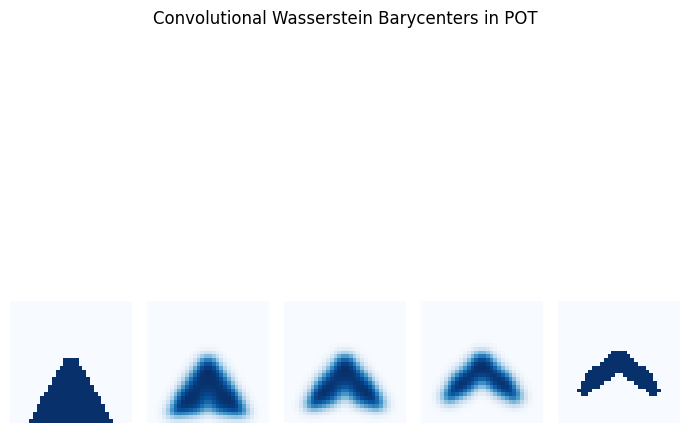

In [226]:
nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("Convolutional Wasserstein Barycenters in POT")
cm = "Blues"

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)

    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        # call to barycenter computation
        axes[i].imshow(
            ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm
        )
    axes[i].axis("off")

plt.tight_layout()
plt.show()